In [1]:
import pandas as pd

In [30]:
df = pd.read_csv('tickets.csv')
print(df.head())
print(df.info())
print(df['Topic_group'].value_counts())

df['Document'] = df['Document'].str.lower()  # Lowercase text
df = df.dropna()  # Drop rows with missing values
df_limited = df
#df_limited = df.sample(n=3000, random_state=42).reset_index(drop=True)

                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB
None
Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, 

In [31]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(df_limited, test_size=0.2, random_state=42)

In [32]:
def prepare_spacy_data(data):
    spacy_data = []
    for _, row in data.iterrows():
        cats = {label: 0 for label in df_limited['Topic_group'].unique()}  # Initialize all labels as 0
        cats[row['Topic_group']] = 1  # Set the correct label as 1
        spacy_data.append((row['Document'], {'cats': cats}))
    return spacy_data

train_data_spacy = prepare_spacy_data(train_data)
val_data_spacy = prepare_spacy_data(val_data)

In [33]:
import spacy
from spacy.pipeline.textcat import Config

nlp = spacy.blank("en")  # Create a blank English model
config = Config()
textcat = nlp.add_pipe("textcat", config=config)

# Add labels to the TextCategorizer
for label in df_limited['Topic_group'].unique():
    textcat.add_label(label)

In [34]:
from spacy.tokens import DocBin

def convert_to_docbin(data, nlp):
    docbin = DocBin()
    for text, annotations in data:
        doc = nlp.make_doc(text)
        doc.cats = annotations['cats']
        docbin.add(doc)
    return docbin

train_docbin = convert_to_docbin(train_data_spacy, nlp)
val_docbin = convert_to_docbin(val_data_spacy, nlp)

train_docbin.to_disk("./train.spacy")
val_docbin.to_disk("./val.spacy")

In [35]:
!python -m spacy init config ./config.cfg --lang en --pipeline textcat --optimize efficiency


✘ The provided output file already exists. To force overwriting the
config file, set the --force or -F flag.



In [36]:
from spacy.tokens import DocBin

# Check training data
train_docbin = DocBin().from_disk("./train.spacy")
train_docs = list(train_docbin.get_docs(nlp.vocab))
print(f"Number of training examples: {len(train_docs)}")
print(f"First example categories: {train_docs[0].cats}")

Number of training examples: 38269
First example categories: {'Hardware': 0, 'Access': 1, 'Miscellaneous': 0, 'HR Support': 0, 'Purchase': 0, 'Administrative rights': 0, 'Storage': 0, 'Internal Project': 0}


In [37]:
!python -m spacy train ./config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./val.spacy

ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.11       12.42    0.12
  0     200         18.45       52.54    0.53
  0     400         14.70       62.00    0.62
  0     600         13.34       69.18    0.69
  0     800         10.19       71.50    0.71
  0    1000         10.14       74.23    0.74
  0    1200          9.85       75.59    0.76
  0    1400          8.42       77.26    0.77
  0    1600          8.83       78.72    0.79
  0    1800          8.06       80.30    0.80
  0    2000          7.32       81.02    0.81
  0    2200          6.99       81.80    0.82
  0    2400          7.07       82.43    0.82
  0    2600          6.50   

In [38]:
import spacy

# Load the trained model
nlp_model = spacy.load("./output/model-best")

# Test on a single example
test_text = "I cannot access the file, I need help with my authorization."
doc = nlp_model(test_text)
sorted_cats = sorted(doc.cats.items(), key=lambda x: x[1], reverse=True)

for label, score in sorted_cats:
    print(f"{label}: {score:.2f}") # predicted labels and scores

Hardware: 0.73
HR Support: 0.10
Storage: 0.05
Access: 0.04
Administrative rights: 0.03
Internal Project: 0.02
Miscellaneous: 0.01
Purchase: 0.00


In [40]:
import shutil

# Export model
shutil.copytree("./output/model-best", "./spacy-text-classification", dirs_exist_ok=True)

'./spacy-text-classification'

In [41]:
import numpy as np

true_labels = []
predicted_labels = []

# Assuming `val_data_spacy` is your validation dataset in spaCy format
for text, annotations in val_data_spacy:
    doc = nlp_model(text)
    # Get the true label
    true_label = max(annotations['cats'], key=annotations['cats'].get)
    true_labels.append(true_label)
    
    # Get the predicted label (highest confidence score)
    predicted_label = max(doc.cats, key=doc.cats.get)
    predicted_labels.append(predicted_label)

In [42]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_true_labels = label_encoder.fit_transform(true_labels)
encoded_predicted_labels = label_encoder.transform(predicted_labels)

# Save the mapping for reference
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {np.str_('Access'): 0, np.str_('Administrative rights'): 1, np.str_('HR Support'): 2, np.str_('Hardware'): 3, np.str_('Internal Project'): 4, np.str_('Miscellaneous'): 5, np.str_('Purchase'): 6, np.str_('Storage'): 7}


In [46]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(encoded_true_labels, encoded_predicted_labels)
print(conf_matrix)

[[1281    6   41   69    5   46    1    6]
 [   2  250   11   65    0   12    2    0]
 [  45    5 1771  170   12   88    2   14]
 [  64   27  142 2374    7  114    9   23]
 [   6    0   33   27  369   15    0    1]
 [  21    2   82   99   16 1172    1    7]
 [   7    5   11   27    2   10  435    0]
 [   6    3   20   23    0   15    2  487]]


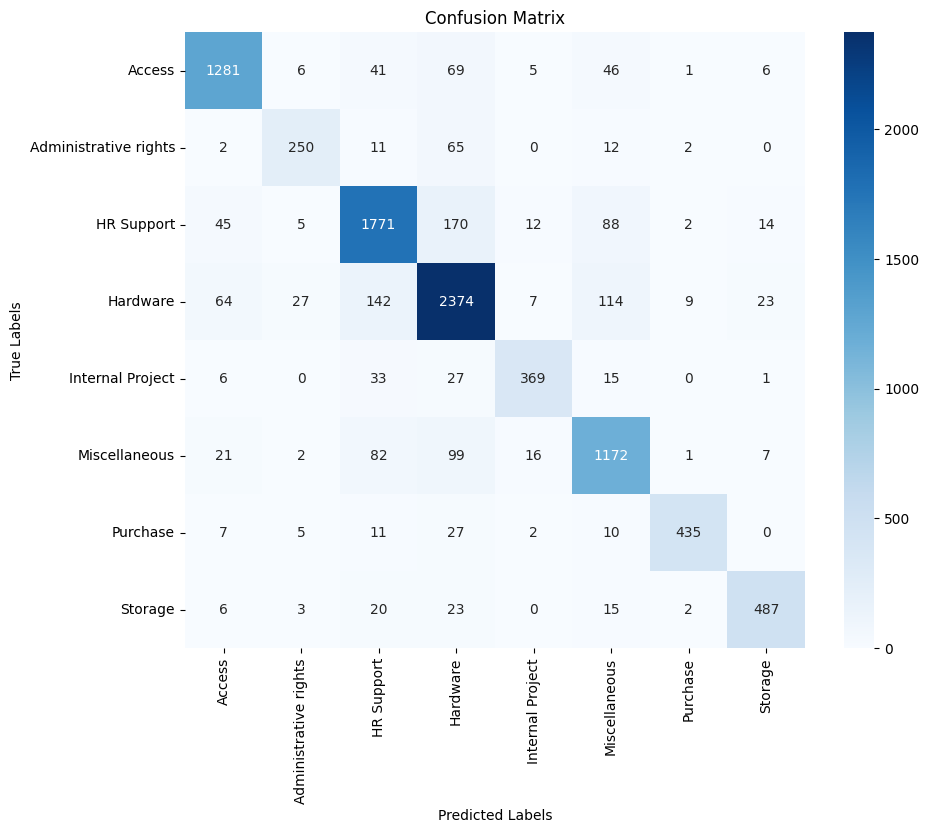

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()